# Water Quality Lesson 1: Locate Lakes and Reservoirs 

**Summary**: In this notebook, we will select Colorado lakes and reservoirs that are detectable by EMIT and ECOSTRESS. We will sub-select the five largest lakes and reservoirs to ensure we have lots of water quality pixels to visualize. We will then find the corresponding granules for extracting the area of interest.

**Objectives**:
1) Learn how to open a GIS file (i.e., a shapefile) in Python
   
3) Utilize Python tools to identify the largest lakes and reservoirs  

**Sections of Notebook**
- Section 1: Data Preparation
- Section 2: Find Relevant Granules

Written By: Kelly Luis, JPL (kelly.m.luis@jpl.nasa.gov)

**Code adapted from the [EMIT Github repo](https://github.com/nasa/EMIT-Data-Resources) and the [VITALS Github repo](https://github.com/nasa/VITALS/). Many thanks to the LP.DAAC team!**

#### TO DO:
1. Adjust Data Path for HYR-SENSE 

In [9]:
# Load Modules
import pandas # Important for Data Manipulation
import numpy as np # Important for Data Manipulation
import geopandas as gpd # Open Shapefiles in Python 
import matplotlib.pyplot as plt # Plotting Function
import earthaccess # Access NASA Data
from shapely.geometry.polygon import orient # Orient Shapefile
import os
import shutil

## Part 1: Data Preparation

We can download shapefiles of [US lakes and waterbodies](https://hub.arcgis.com/datasets/esri::usa-detailed-water-bodies/about)from ESRI and use ArcGIS, QGIS, or python geopandas (gpd). For this demonstration, I clipped all of the shapefiles in the state of Colorado in QGIS and this shapefile is available in the HYR-SENSE data store.


In [11]:
# Identify the location of the HYR-SENSE "data store"
#data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/water_quality'
# Set a destination path (this is a 'local' and temporary path)
#dest = '/home/jovyan/HYR-SENSE/data/water_quality/' # in the GitHub repo we cloned
#if not os.path.exists(dest):
#    os.mkdir(dest) # create the directory for the copied data, if needed
# Using 'shutil' package, copy all the files over
#shutil.copytree(data_store_path, dest, dirs_exist_ok=True)

In [12]:
# Load Geopandas File with Lakes and Reservoirs
lr_gdf = gpd.read_file('data/co_lr/co_lr.shp')
print(len(lr_gdf))

# Visualize First 5 Entries
lr_gdf.head()

7272


,OBJECTID,NAME,FTYPE,FCODE,FCODE_DESC,SQKM,SQMI,geometry
0,31720,None,Stream/River,46006,Stream/River: Hydrographic Category = Perennial,8.53,3.29,"POLYGON ((-107.75863 40.39502, -107.75893 40.3..."
1,31721,None,Lake/Pond,39001,Lake/Pond: Hydrographic Category = Intermittent,0.03,0.01,"POLYGON ((-107.92224 40.44486, -107.92251 40.4..."
2,31722,None,Lake/Pond,39001,Lake/Pond: Hydrographic Category = Intermittent,0.02,0.01,"POLYGON ((-107.85354 40.33381, -107.85357 40.3..."
3,31723,None,Lake/Pond,39004,Lake/Pond: Hydrographic Category = Perennial,0.14,0.06,"POLYGON ((-108.35394 40.59423, -108.35406 40.5..."
4,31724,None,Lake/Pond,39001,Lake/Pond: Hydrographic Category = Intermittent,0.01,0.01,"POLYGON ((-108.27277 40.54833, -108.27307 40.5..."


In [13]:
# Subselect for Lake/Pond and Reservoir, Order by Size, Drop NA rows
sub_gdf = lr_gdf[lr_gdf['FTYPE'].isin({'Lake/Pond', 'Reservoir'})].sort_values('SQKM', ascending=False).dropna()

,OBJECTID,NAME,FTYPE,FCODE,FCODE_DESC,SQKM,SQMI,geometry
653,33687,Navajo Reservoir,Lake/Pond,39009,Lake/Pond: Hydrographic Category = Perennial; ...,62.23,24.03,"MULTIPOLYGON (((-107.40077 37.00001, -107.4028..."
6600,43123,"Meredith, Lake",Lake/Pond,39009,Lake/Pond: Hydrographic Category = Perennial; ...,22.39,8.65,"POLYGON ((-103.73971 38.15313, -103.73994 38.1..."
2954,37396,Dillon Reservoir,Lake/Pond,39010,Lake/Pond: Hydrographic Category = Perennial; ...,12.94,4.99,"POLYGON ((-106.04899 39.56965, -106.04904 39.5..."
7076,43606,Neenoshe Reservoir,Lake/Pond,39009,Lake/Pond: Hydrographic Category = Perennial; ...,12.82,4.95,"POLYGON ((-102.67934 38.35004, -102.67838 38.3..."
1674,34797,Elevenmile Canyon Reservoir,Lake/Pond,39010,Lake/Pond: Hydrographic Category = Perennial; ...,12.63,4.88,"POLYGON ((-105.47853 38.89399, -105.47899 38.8..."


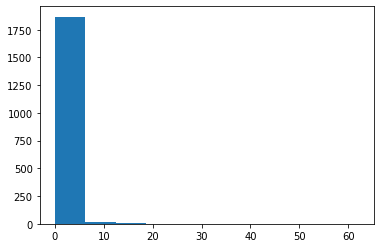

In [14]:
# Look at spatial area of lakes and reservoirs
plt.hist(sub_gdf.SQKM)
sub_gdf.head(n=5)

Navajo Reservoir
Meredith, Lake
Dillon Reservoir
Neenoshe Reservoir
Elevenmile Canyon Reservoir


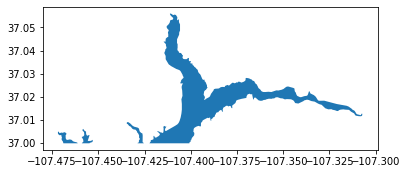

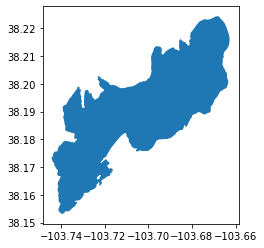

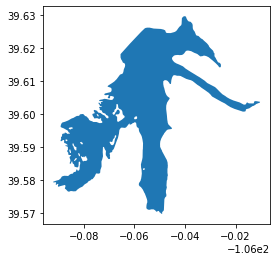

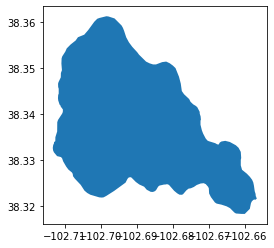

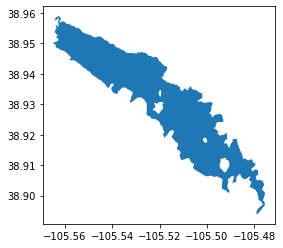

In [16]:
# Visualize the Shape of the Lakes and Reservoirs
for lake_name in sub_gdf['NAME'].head():
    print(lake_name)
    sub_gdf[sub_gdf['NAME'] == lake_name].plot()

## Questions To Think About

1. Based on the histogram above, what size (i.e., SQKM) are a majority of the water bodies in the state of Colorado?
2. From the visualizations of the five largest lakes, what types of external influences might there be on the lake water quality (i.e., rivers, wetlands, etc.)?

## Section 2: Find Relevant Granules

To see the difference in water qualtiy retrievals between big lakes and small lakes, we will extract relevant granules for a large water body (i.e., Neenoshe Reservoir) and utilize a bounding box to find water bodies in the Niwot Ridge, where we will be visiting on Thursday. 

### Polygon shapefile for Neenoshe Reservoir

In [17]:
## Set Up Shapefile ROI 
polygon = sub_gdf[sub_gdf['NAME'] == 'Neenoshe Reservoir']
roi_poly = polygon.unary_union.envelope
roi_poly = orient(roi_poly, sign=1.0)
roi = list(roi_poly.exterior.coords)
print(roi)

# Specify start (sdate) and end (edate) dates of query with EMIT timeline
sdate = '2022-08-01 00:00:00' 
edate = '2024-05-31 00:00:00'

# Search for EMIT Data
emit_results = earthaccess.search_data(
    short_name='EMITL2ARFL', # Short name for EMIT Level 2 Reflectance
    polygon=roi, # ROI from Shapefile
    temporal=(sdate, edate), # Start Date, End Date
    cloud_cover=(0,5), # Minimum, Maximum Cloud Fraction 
    count=100)

[(-102.713343900434, 38.318352175617), (-102.656813822605, 38.318352175617), (-102.656813822605, 38.3613052628939), (-102.713343900434, 38.3613052628939), (-102.713343900434, 38.318352175617)]
Granules found: 8


In [18]:
# Visualize Links and RGB Maps
emit_results[0]

Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -102.71772003173828, 'Latitude': 38.8682746887207}, {'Longitude': -103.6136703491211, 'Latitude': 38.27639389038086}, {'Longitude': -103.17089080810547, 'Latitude': 37.606136322021484}, {'Longitude': -102.27494049072266, 'Latitude': 38.19801712036133}, {'Longitude': -102.71772003173828, 'Latitude': 38.8682746887207}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-04-03T19:05:44Z', 'EndingDateTime': '2023-04-03T19:05:56Z'}}
Size(MB): 3579.340545654297
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230403T190544_2309313_020/EMIT_L2A_RFL_001_20230403T190544_2309313_020.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230403T190544_2309313_020/EMIT_L2A_RFLUNCERT_001_20230403T190544_2309313_020.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230403T190544_2309313_020/EMIT_L2A_MASK_001_20230403T190544_2309313_020.nc']

In [19]:
# ECOSTRESS
# Utilize EMIT's "BeginningDateTime" and "EndingDateTime" to find an overlapping ECOSTRESS file
sdate_eco = "2023-04-03 19:04:00"
edate_eco = "2023-04-03 19:07:00"

eco_results = earthaccess.search_data(
    short_name='ECO_L2T_LSTE', # Short name for EMIT Level 2 Reflectance
    polygon=roi, # ROI from Shapefile
    temporal=(sdate_eco, edate_eco), # Start Date, End Date
    count=100)

Granules found: 2


In [10]:
eco_results[0]

Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -102.727623, 'EastBoundingCoordinate': -101.434006, 'NorthBoundingCoordinate': 38.826283, 'SouthBoundingCoordinate': 37.807232}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-04-03T19:05:28.820Z', 'EndingDateTime': '2023-04-03T19:06:20.790Z'}}
Size(MB): 18.735
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_cloud.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_view_zenith.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_height.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_QC.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_LST.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_LST_err.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01/ECOv002_L2T_LSTE_26890_005_13SGC_20230403T190528_0710_01_EmisWB.tif']

### Bounding Box for Niwot Ridge Lakes

In [20]:
# Grab a boundary 
N=40.098205
W=-105.632479
S=40.025344 
E=-105.553366

# Specify start (sdate) and end (edate) dates of query
sdate = '2022-08-01 00:00:00' 
edate = '2024-05-31 00:00:00'

# EMIT 
emit_results = earthaccess.search_data(
    short_name='EMITL2ARFL', # Short name for EMIT Level 2 Reflectance
    bounding_box=(W, S, E, N), # Bounding Box: West, South, East North
    temporal=(sdate, edate), # Start Date, End Date
    cloud_cover=(0,20), # Minimum, Maximum Cloud Fraction 
    count=100)

Granules found: 1


In [21]:
# Display File Contents
emit_results

[Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.92611694335938, 'Latitude': 40.60380172729492}, {'Longitude': -106.3302001953125, 'Latitude': 39.925174713134766}, {'Longitude': -105.47183227539062, 'Latitude': 39.414066314697266}, {'Longitude': -105.0677490234375, 'Latitude': 40.09269332885742}, {'Longitude': -105.92611694335938, 'Latitude': 40.60380172729492}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-25T17:08:14Z', 'EndingDateTime': '2023-06-25T17:08:26Z'}}
 Size(MB): 3581.195469856262
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFLUNCERT_001_20230625T170814_2

In [13]:
# Look at Data Types and RGB
emit_results[0]

Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.92611694335938, 'Latitude': 40.60380172729492}, {'Longitude': -106.3302001953125, 'Latitude': 39.925174713134766}, {'Longitude': -105.47183227539062, 'Latitude': 39.414066314697266}, {'Longitude': -105.0677490234375, 'Latitude': 40.09269332885742}, {'Longitude': -105.92611694335938, 'Latitude': 40.60380172729492}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-25T17:08:14Z', 'EndingDateTime': '2023-06-25T17:08:26Z'}}
Size(MB): 3581.195469856262
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFLUNCERT_001_20230625T170814_2317611_005.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_MASK_001_20230625T170814_2317611_005.nc']

In [14]:
# ECOSTRESS
# Utilize EMIT's "BeginningDateTime" and "EndingDateTime" to find an overlapping ECOSTRESS file
sdate_eco = "2023-06-25 17:08:14"
edate_eco = "2023-06-25 17:08:26"

eco_results = earthaccess.search_data(
    short_name='ECO_L2T_LSTE', # Short name for EMIT Level 2 Reflectance
    bounding_box=(W, S, E, N), # Bounding Box: West, South, East North
    temporal=(sdate_eco, edate_eco), # Start Date, End Date
    count=100)

Granules found: 1


In [15]:
#Display File Contents
eco_results

[Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -106.18317260659883, 'EastBoundingCoordinate': -104.88503005879925, 'NorthBoundingCoordinate': 40.65079928293903, 'SouthBoundingCoordinate': 39.65611291096908}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-25T17:07:39.693Z', 'EndingDateTime': '2023-06-25T17:08:31.664Z'}}
 Size(MB): 20.17
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_cloud.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_

In [16]:
# Look at Data Types and RGB
eco_results[0]

Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -106.18317260659883, 'EastBoundingCoordinate': -104.88503005879925, 'NorthBoundingCoordinate': 40.65079928293903, 'SouthBoundingCoordinate': 39.65611291096908}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-25T17:07:39.693Z', 'EndingDateTime': '2023-06-25T17:08:31.664Z'}}
Size(MB): 20.17
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_cloud.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_view_zenith.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_height.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_QC.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_LST.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_LST_err.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01/ECOv002_L2T_LSTE_28176_004_13TDE_20230625T170739_0710_01_EmisWB.tif']

## Additional Resources

- [US Water Bodies Shapefile](https://hub.arcgis.com/maps/esri::usa-detailed-water-bodies]) 